In [1]:
# import necessary package for the project
%pip install scikit-lego
%pip install tensorflow
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklego.linear_model import LADRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.6/219.6 kB 3.4 MB/s eta 0:00:00


the laptop_prices dataset is from https://www.kaggle.com/datasets/owm4096/laptop-prices

Since it is a processed dataset, there is no missing value and we don't see a necessity to conduct any intial data clearning. Basic info can be found below such as dimension, variable type, etc.

We try to predict Price_euros (response variable) with other variables available in the dataset. Preliminary analysis is conducted and could be found below. We believe some features would have a impact on the Price_eros based on a real life experiences, such as larger screen / larger storage tends to make price higher.

In [2]:
# load in dataset
df_orig = pd.read_csv('/content/laptop_prices.csv')
df_orig.shape

(1275, 23)

In [4]:
df_orig.head(6)

,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,...,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
0,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,...,Yes,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640
1,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,...,No,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000
2,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,...,No,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620
3,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,Standard,2880,...,Yes,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455
4,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,Standard,2560,...,Yes,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650
5,Acer,Aspire 3,Notebook,15.6,4,Windows 10,2.10,400.00,Standard,1366,...,No,AMD,3.0,A9-Series 9420,500,0,HDD,No,AMD,Radeon R5


In [5]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1275 non-null   object 
 1   Product               1275 non-null   object 
 2   TypeName              1275 non-null   object 
 3   Inches                1275 non-null   float64
 4   Ram                   1275 non-null   int64  
 5   OS                    1275 non-null   object 
 6   Weight                1275 non-null   float64
 7   Price_euros           1275 non-null   float64
 8   Screen                1275 non-null   object 
 9   ScreenW               1275 non-null   int64  
 10  ScreenH               1275 non-null   int64  
 11  Touchscreen           1275 non-null   object 
 12  IPSpanel              1275 non-null   object 
 13  RetinaDisplay         1275 non-null   object 
 14  CPU_company           1275 non-null   object 
 15  CPU_freq             

In [4]:
# Set random seed for reproducibility
np.random.seed(148)

# Shuffle the dataframe
df_shuffled = df_orig.sample(frac=1, random_state=148).reset_index(drop=True)

# Calculate the sizes for the splits
train_size = int(0.6 * len(df_shuffled))
val_size = int(0.25 * len(df_shuffled))

# Split the dataframe
df_train = df_shuffled[:train_size]
df_val = df_shuffled[train_size:train_size + val_size]
df_test = df_shuffled[train_size + val_size:]

# Display the sizes of each split
print(f"Train set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

Train set size: 765
Validation set size: 318
Test set size: 192


All the EDA are done on df_train for now

In [7]:
#1 number of categorical var and number of numerical var
categorical_vars = df_orig.select_dtypes(include=['object'])
numerical_vars = df_orig.select_dtypes(include=['number'])

# Counting the number of categorical and numerical variables in the dataset
num_categorical_vars = len(categorical_vars.columns)
num_numerical_vars = len(numerical_vars.columns)

print("# of categorical variables:",num_categorical_vars," # of categorical variables: ",num_numerical_vars)
# Listing all the categorical and numerical variables in the dataset
categorical_vars_list = list(categorical_vars.columns)
numerical_vars_list = list(numerical_vars.columns)

categorical_vars_list, numerical_vars_list

# of categorical variables: 14  # of categorical variables:  9


(['Company',
  'Product',
  'TypeName',
  'OS',
  'Screen',
  'Touchscreen',
  'IPSpanel',
  'RetinaDisplay',
  'CPU_company',
  'CPU_model',
  'PrimaryStorageType',
  'SecondaryStorageType',
  'GPU_company',
  'GPU_model'],
 ['Inches',
  'Ram',
  'Weight',
  'Price_euros',
  'ScreenW',
  'ScreenH',
  'CPU_freq',
  'PrimaryStorage',
  'SecondaryStorage'])

In [6]:
#2_corr matrix of all numerical
corr_matrix = numerical_vars.corr()
corr_matrix

,Inches,Ram,Weight,Price_euros,ScreenW,ScreenH,CPU_freq,PrimaryStorage,SecondaryStorage
Inches,1.000000,0.241078,0.826638,0.066608,-0.068223,-0.093062,0.305037,0.264280,0.389067
Ram,0.241078,1.000000,0.389370,0.740287,0.424089,0.415241,0.366254,0.015365,0.390939
Weight,0.826638,0.389370,1.000000,0.211883,-0.028605,-0.050106,0.318649,0.175433,0.481495
Price_euros,0.066608,0.740287,0.211883,1.000000,0.552491,0.548529,0.428847,-0.124775,0.291207
ScreenW,-0.068223,0.424089,-0.028605,0.552491,1.000000,0.994069,0.178659,-0.072977,0.146232
ScreenH,-0.093062,0.415241,-0.050106,0.548529,0.994069,1.000000,0.164369,-0.080135,0.135293
CPU_freq,0.305037,0.366254,0.318649,0.428847,0.178659,0.164369,1.000000,0.056320,0.224521
PrimaryStorage,0.264280,0.015365,0.175433,-0.124775,-0.072977,-0.080135,0.056320,1.000000,-0.244182
SecondaryStorage,0.389067,0.390939,0.481495,0.291207,0.146232,0.135293,0.224521,-0.244182,1.000000


In [7]:
#3 Summary Statistics
summary_numerical = numerical_vars.describe().loc[['min', '25%', '50%', '75%', 'max']]
summary_categorical = categorical_vars.describe()
# Display the result
print("Summary Statistics for Numerical Variables:")
print(summary_numerical)

print("\nSummary Statistics for Categorical Variables:")
print(summary_categorical)

Summary Statistics for Numerical Variables:
     Inches   Ram  Weight  Price_euros  ScreenW  ScreenH  CPU_freq  \
min    10.1   2.0    0.69        174.0   1366.0    768.0       0.9   
25%    14.0   4.0    1.50        609.0   1920.0   1080.0       2.0   
50%    15.6   8.0    2.04        989.0   1920.0   1080.0       2.5   
75%    15.6   8.0    2.31       1496.5   1920.0   1080.0       2.7   
max    18.4  64.0    4.70       6099.0   3840.0   2160.0       3.6   

     PrimaryStorage  SecondaryStorage  
min             8.0               0.0  
25%           256.0               0.0  
50%           256.0               0.0  
75%           512.0               0.0  
max          2048.0            2048.0  

Summary Statistics for Categorical Variables:
       Company Product  TypeName          OS   Screen Touchscreen IPSpanel  \
count     1275    1275      1275        1275     1275        1275     1275   
unique      19     618         6           9        4           2        2   
top       Dell

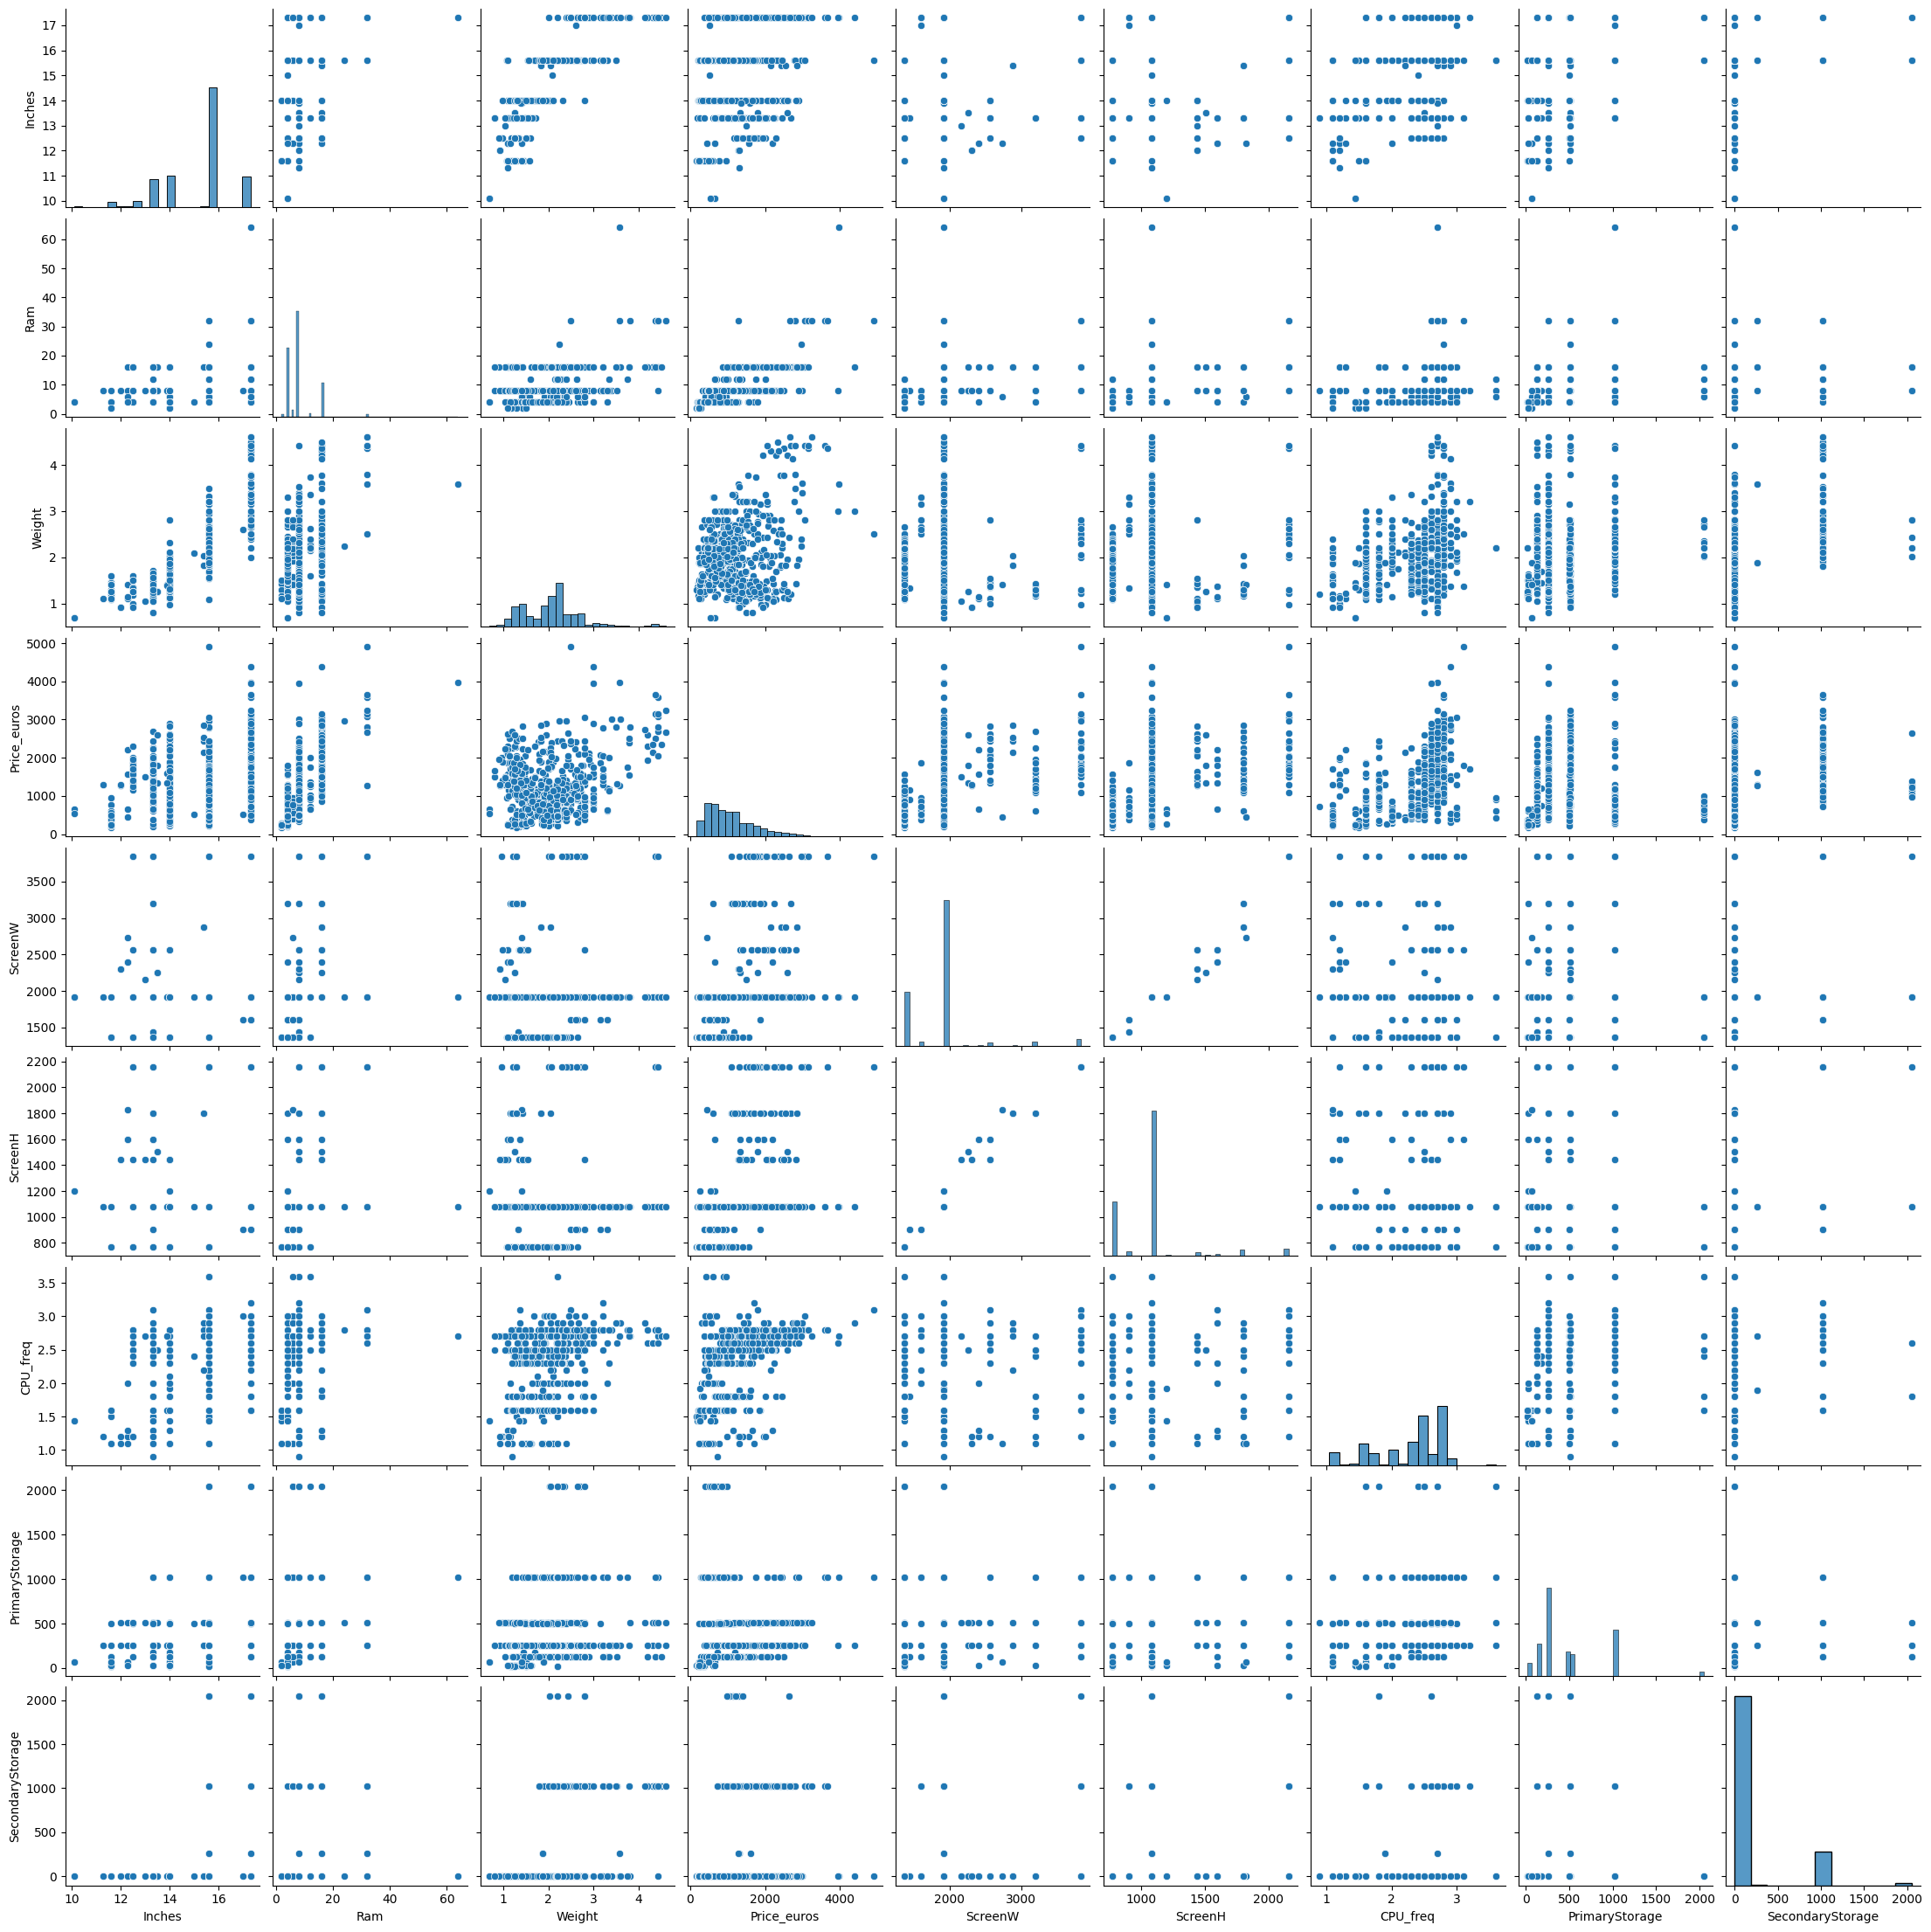

In [8]:
#4 pairwise plot to demonstrate linear relationships between numerical columns
sns.pairplot(df_train[numerical_vars.columns])
plt.show()

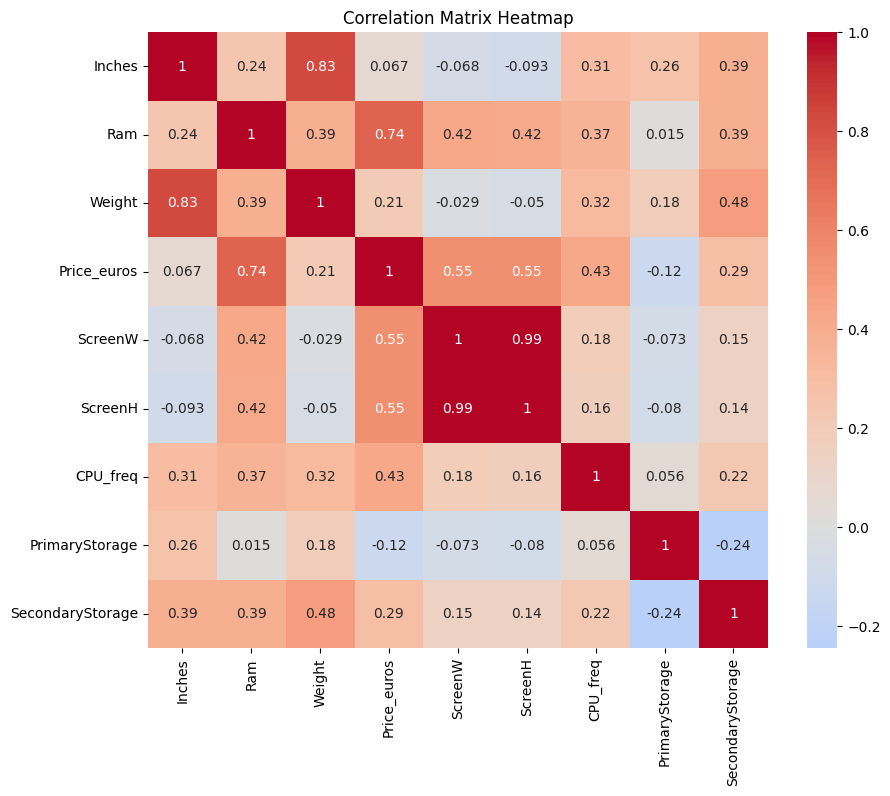

In [9]:
#4 correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

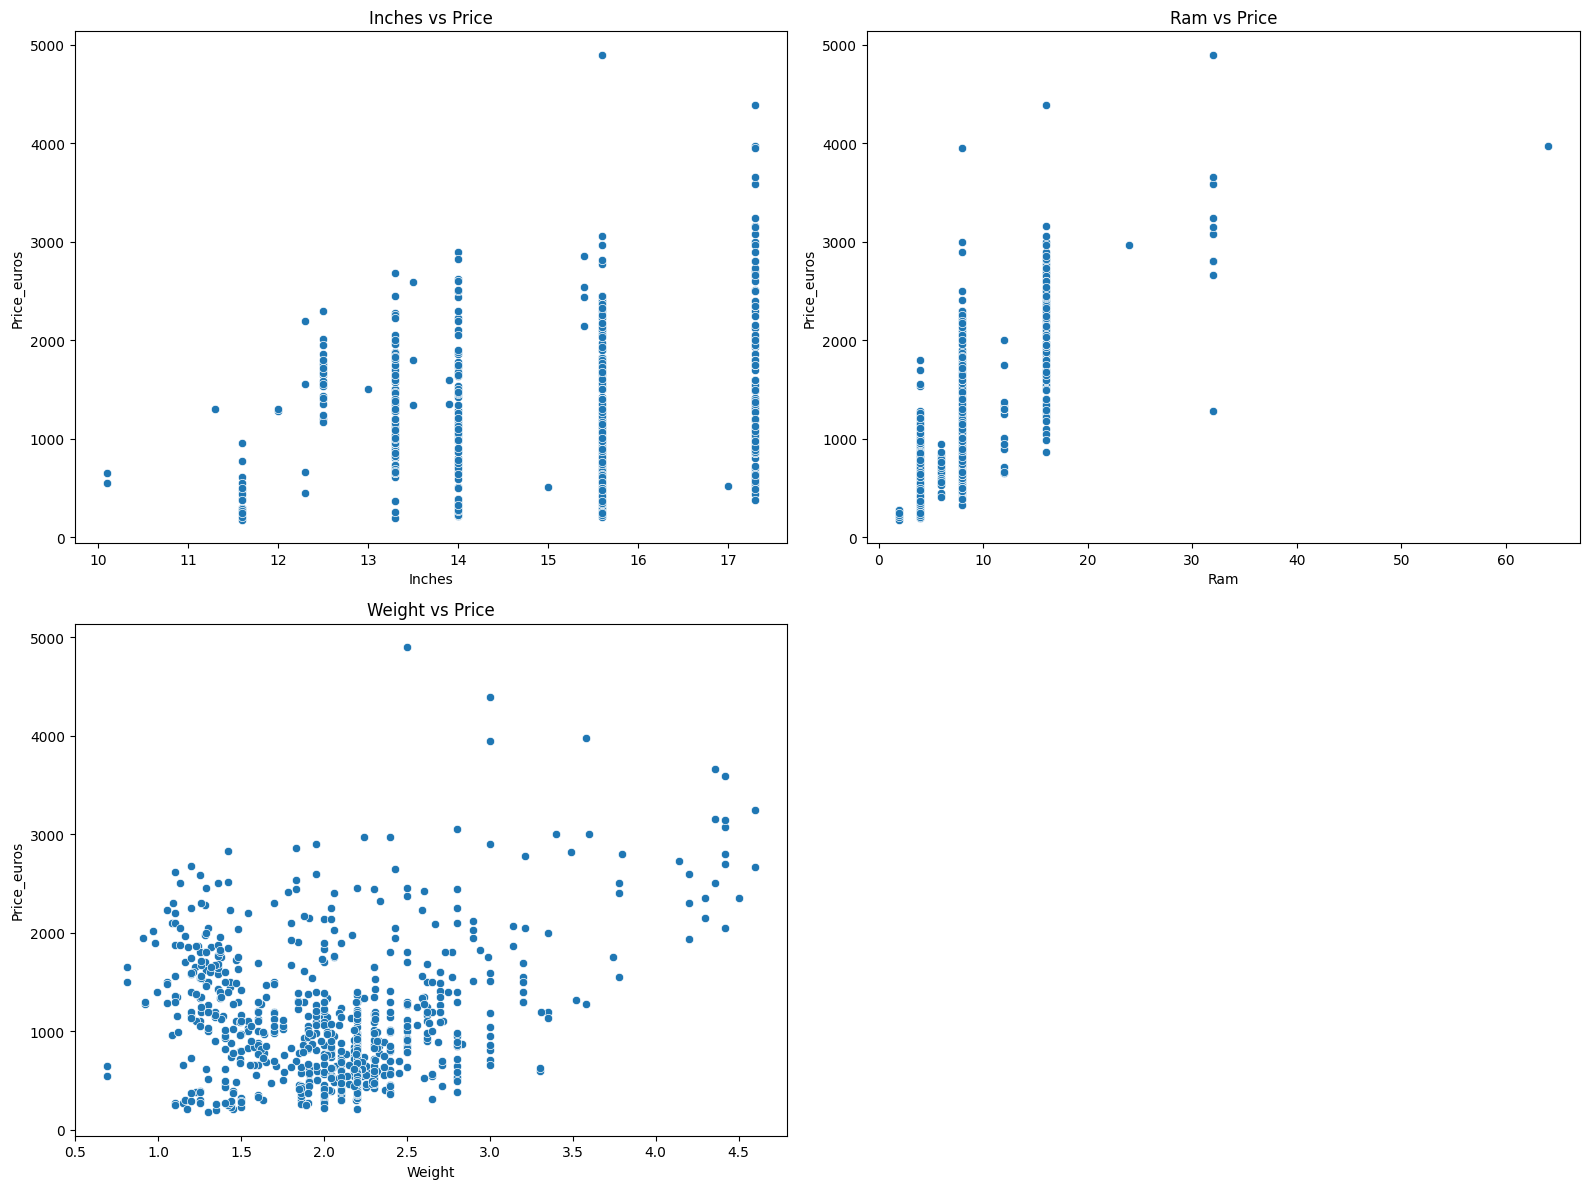

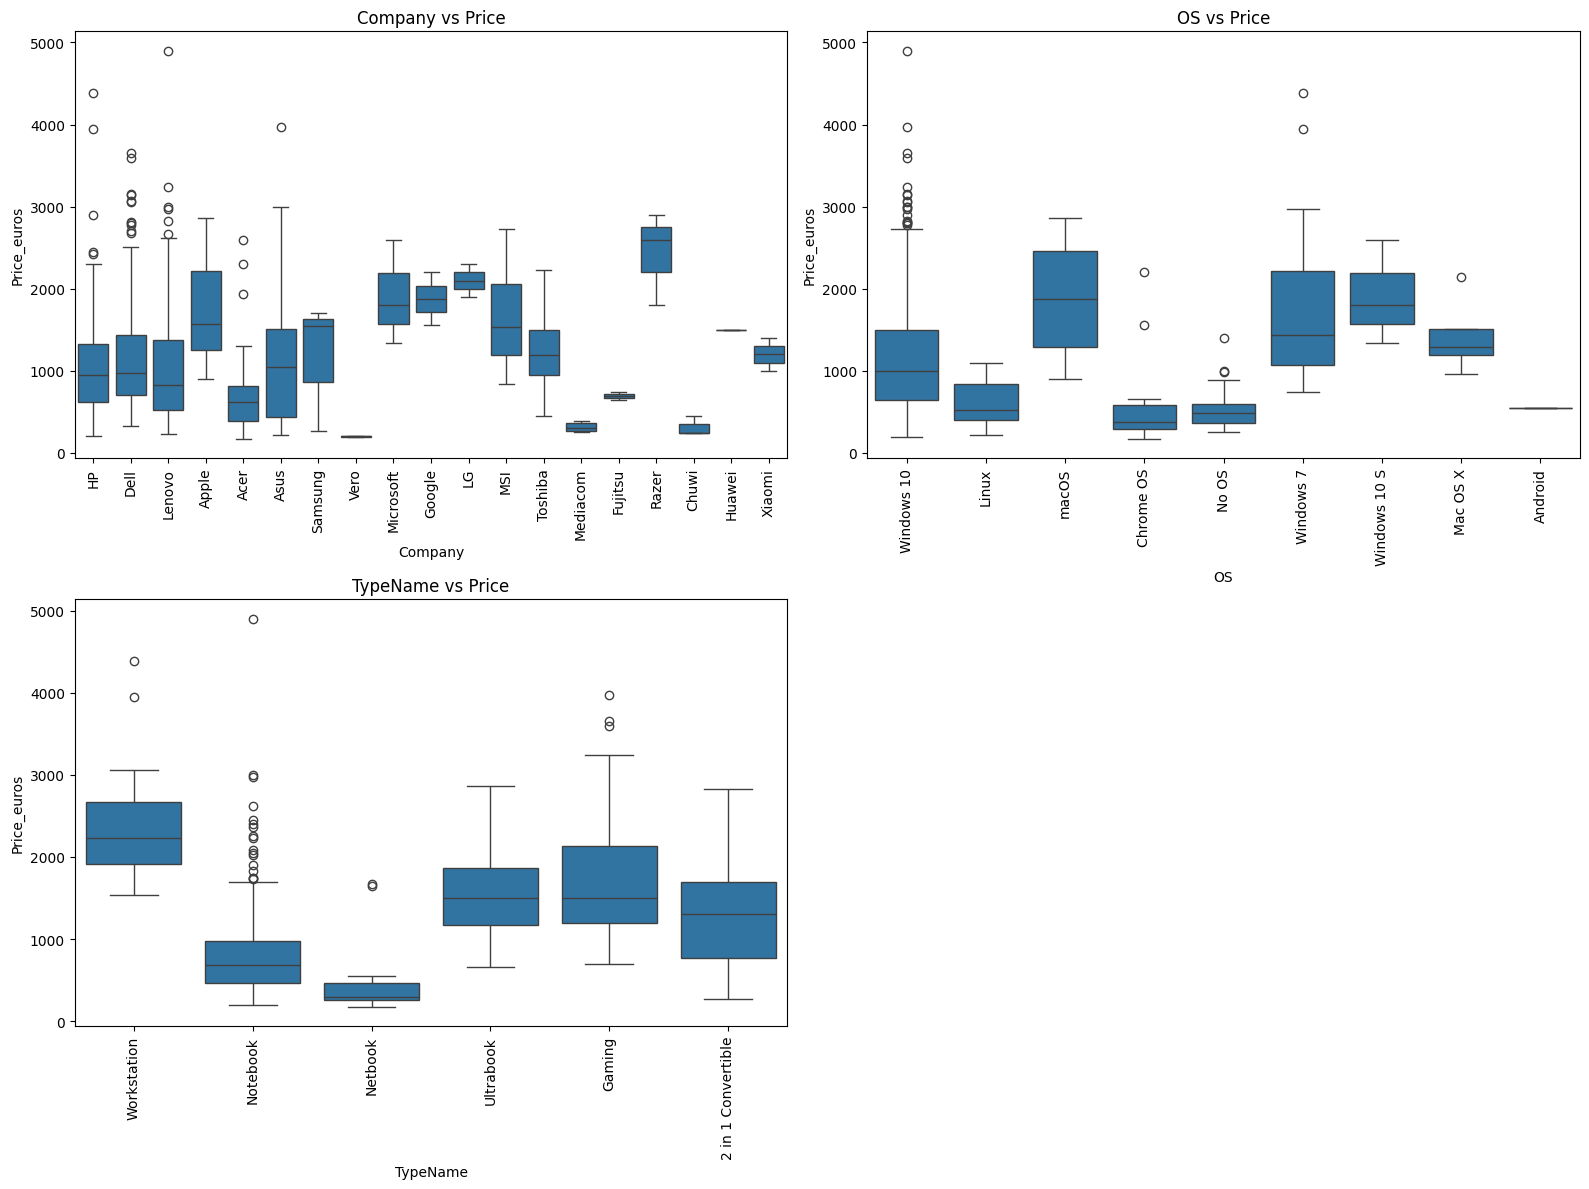

In [10]:
#5 plotting of 3 categorical and 3 numerical features vs price
# Plot 1: Continuous variables
plt.figure(figsize=(16, 12))

# Inches vs Price
# Generally greater inches has greater price, indicating larger screen sizes might correlate with higher prices.
# BUT there are also laptops with smaller screens that are priced high, indicating other influencing factors like brand or specifications.
plt.subplot(2, 2, 1)
sns.scatterplot(x='Inches', y='Price_euros', data=df_train)
plt.title('Inches vs Price')

# Ram vs Price
# more RAM is associated with higher prices
plt.subplot(2, 2, 2)
sns.scatterplot(x='Ram', y='Price_euros', data=df_train)
plt.title('Ram vs Price')

# Weight vs Price
# no strong correlation between weight and price
plt.subplot(2, 2, 3)
sns.scatterplot(x='Weight', y='Price_euros', data=df_train)
plt.title('Weight vs Price')
plt.tight_layout()
plt.show()

# Plot 2: Categorical variables
plt.figure(figsize=(16, 12))

# Company vs Price
# brands like Apple, Google, Razar, and Microsoft that have premium market positioning dominate the upper price range
plt.subplot(2, 2, 1)
sns.boxplot(x='Company', y='Price_euros', data=df_train)
plt.xticks(rotation=90)
plt.title('Company vs Price')


# OS vs Price
# MacOS and Windows 7/10 laptops tend to be pricier
plt.subplot(2, 2, 2)
sns.boxplot(x='OS', y='Price_euros', data=df_train)
plt.xticks(rotation=90)
plt.title('OS vs Price')

# TypeName vs Price
# Workstations and gaming laptops are priced higher
plt.subplot(2, 2, 3)
sns.boxplot(x='TypeName', y='Price_euros', data=df_train)
plt.xticks(rotation=90)
plt.title('TypeName vs Price')

plt.tight_layout()
plt.show()

In [14]:
# Implement always predict mean model as the benchmark, compute rooted MSE on train and test set

# Calculate the mean of the target variable in the training set
train_mean = df_train['Price_euros'].mean()

# Predict the mean for all instances in the training and test sets
y_train_pred = [train_mean] * len(df_train)
y_test_pred = [train_mean] * len(df_test)

# Calculate the root mean squared error (RMSE) for the training and test sets
train_rmse = np.sqrt(mean_squared_error(df_train['Price_euros'], y_train_pred))
test_rmse = np.sqrt(mean_squared_error(df_test['Price_euros'], y_test_pred))

# Print the RMSE values
print(train_mean)
print(f"Train rMSE: {train_rmse}")
print(f"Test rMSE: {test_rmse}")
# we get y hat = 1114.98

1114.9815686274508
Train rMSE: 693.2595784354093
Test rMSE: 656.05947776343


In [11]:
# Check-in 2 starts from here (linear regression)
# We select Price_euros as response variable, and Ram as predictor as they have highest correlation
lad_fit = LADRegression() # L1
lad_fit.fit(X=np.array(df_train['Ram']).reshape(-1, 1), y=df_train['Price_euros'])
print('LAD intercept:',lad_fit.intercept_, 'LAD coefficient', lad_fit.coef_[0])

ls_fit = LinearRegression() # L2
ls_fit.fit(X=np.array(df_train['Ram']).reshape(-1, 1), y=df_train['Price_euros'])
print('LS intercept:', ls_fit.intercept_, 'LS coefficient', ls_fit.coef_[0])

LAD intercept: 84.55999999969671 LAD coefficient 115.27750000001757
LS intercept: 287.63527579582444 LS coefficient 99.42191549107667


In [15]:
# plot the Price_euros vs Ram scatter plot and two regression models
fig = px.scatter(df_train, x='Ram', y='Price_euros', title='Price_euros vs Ram')
fig.add_trace(
    go.Scatter(x=df_train['Ram'],
    y=lad_fit.intercept_ + df_train['Ram'] * lad_fit.coef_[0],
    mode='lines', name='LAD Regression')
)

fig.add_trace(
    go.Scatter(x=df_train['Ram'],
    y=ls_fit.intercept_ + df_train['Ram'] * ls_fit.coef_[0],
    mode='lines', name='LS Regression')
)

Notice that Ram here is not a completely numerical variable in some sense given it only takes several integer value. May consider trying other variables and multi-variable regression in the future.

In [16]:
# Create a  3 column dataframe demontrating real, LAD prediction, LS prediction
pred_val_df = pd.DataFrame(
    {
        'true': df_val['Price_euros'],
        'lad_pred': lad_fit.predict(np.array(df_val['Ram']).reshape(-1, 1)),
        'ls_pred': ls_fit.predict(np.array(df_val['Ram']).reshape(-1, 1))
    }
)
pred_val_df

,true,lad_pred,ls_pred
765,2289.99,1929.00,1878.385924
766,889.00,1006.78,1083.010600
767,3499.00,1929.00,1878.385924
768,1510.00,1006.78,1083.010600
769,797.41,1006.78,1083.010600
...,...,...,...
1078,1399.00,1006.78,1083.010600
1079,699.00,545.67,685.322938
1080,2639.00,3773.44,3469.136572
1081,1686.64,1006.78,1083.010600


In [17]:
# calculate rMSE, MAE, MAD, correlation, R2 of true price with LS & LAD predictions
print('LS rMSE:', np.sqrt(mean_squared_error(pred_val_df['true'], pred_val_df['ls_pred'])))
print('LS MAE:', mean_absolute_error(pred_val_df['true'], pred_val_df['ls_pred']))
print('LS MAD:', np.median(np.abs(pred_val_df['true'] - pred_val_df['ls_pred'])))
print('LS correlation:', np.corrcoef(pred_val_df['true'], pred_val_df['ls_pred'])[0, 1])
print('LS R2:', r2_score(pred_val_df['true'], pred_val_df['ls_pred']))

print('LAD rMSE:', np.sqrt(mean_squared_error(pred_val_df['true'], pred_val_df['lad_pred'])))
print('LAD MAE:', mean_absolute_error(pred_val_df['true'], pred_val_df['lad_pred']))
print('LAD MAD:', np.median(np.abs(pred_val_df['true'] - pred_val_df['lad_pred'])))
print('LAD correlation:', np.corrcoef(pred_val_df['true'], pred_val_df['lad_pred'])[0, 1])
print('LAD R2:', r2_score(pred_val_df['true'], pred_val_df['lad_pred']))

LS rMSE: 507.5156994969675
LS MAE: 370.6725851745604
LS MAD: 289.16676874228443
LS correlation: 0.7349746051049965
LS R2: 0.530896864818839
LAD rMSE: 513.6157402931136
LAD MAE: 365.3441352201324
LAD MAD: 248.995
LAD correlation: 0.734974605104998
LAD R2: 0.5195524065873021


LS Model: Slightly better in terms of overall fit (higher R², lower rMSE), but has a higher MAE and MAD.

LAD Model: Performs better in minimizing absolute errors (lower MAE and MAD), which makes sense as it L1 loss function penalize less on the absolute deviance.

In general, the errors are high, suggesting the performace for single variable regression model is not ideal. In terms of future improvements, we plan to 1. improve the feature engineering and select more predictors to involve in the linear regression model; 2. try more complex models since there's a chance that the relations for price vs other features aren't best described by linear model.

Based on the figure above, we can't really see any overfitting and underfitting problem. We only use one predictor, the chance of overfit the train set is low. For underfitting problem, both models successfully track the overall uptrend, though errors are relatively high.

In [18]:
# apply ridge regression on the ls_fit model
ridge_fit = Ridge(alpha=1.0)
ridge_fit.fit(X=np.array(df_train['Ram']).reshape(-1, 1), y=df_train['Price_euros'])
print('Ridge intercept:', ridge_fit.intercept_, 'Ridge coefficient:', ridge_fit.coef_[0])

Ridge intercept: 287.6750713949823 Ridge coefficient: 99.41713326780369


Out current regression involves just one feature (Ram), we use Ridge Regression. It regularize the coefficient without driving it to zero (which Lasso might do in some case), thus improving the LS model’s predictive performance by reducing overfitting.

In [19]:
# calculate rMSE, MAE, MAD, correlation, R2 of true price with Ridge predictions
pred_val_df['ridge_pred'] = ridge_fit.predict(np.array(df_val['Ram']).reshape(-1, 1))

print('Ridge rMSE:', np.sqrt(mean_squared_error(pred_val_df['true'], pred_val_df['ridge_pred'])))
print('Ridge MAE:', mean_absolute_error(pred_val_df['true'], pred_val_df['ridge_pred']))
print('Ridge MAD:', np.median(np.abs(pred_val_df['true'] - pred_val_df['ridge_pred'])))
print('Ridge correlation:', np.corrcoef(pred_val_df['true'], pred_val_df['ridge_pred'])[0, 1])
print('Ridge R2:', r2_score(pred_val_df['true'], pred_val_df['ridge_pred']))

Ridge rMSE: 507.5185650419886
Ridge MAE: 370.67442316655104
Ridge MAD: 289.17787100180453
Ridge correlation: 0.7349746051049979
Ridge R2: 0.5308915674853786


The metrics suggest that Ridge didn't offer a better performance vs least_squre model. The particuar reason is that we only invole one predictor in the model, and there isn't overfitting concern. Hence, regularize the model with Ridge won't significantly improve our model. We tried to tune the alpha value, but they all generate similar rMSE, MAE, etc.

In [21]:
# train multi-predictor ls model on Ram ScreenH ScreenW CPU_freq SecondaryStorage to predict Price_euros,
# predictors are selected based on correlation with the response variable
ls_fit2 = LinearRegression() # L2
ls_fit2.fit(X=df_train[['Ram', 'ScreenH', 'ScreenW', 'CPU_freq', 'SecondaryStorage']], y=df_train['Price_euros'])
print('LS intercept:', ls_fit.intercept_, 'LS coefficient', ls_fit2.coef_)

LS intercept: 287.63527579582444 LS coefficient [ 7.50605502e+01  1.24123651e+00 -3.39109718e-01  2.64790768e+02
  3.63551711e-02]


In [22]:
# Predict using the multi-variable model
pred_val_df['ls_fit2_pred'] = ls_fit2.predict(df_val[['Ram', 'ScreenH', 'ScreenW', 'CPU_freq', 'SecondaryStorage']])

# Calculate and print the metrics for the multi-variable model
print('LS_fit2 rMSE:', np.sqrt(mean_squared_error(pred_val_df['true'], pred_val_df['ls_fit2_pred'])))
print('LS_fit2 MAE:', mean_absolute_error(pred_val_df['true'], pred_val_df['ls_fit2_pred']))
print('LS_fit2 MAD:', np.median(np.abs(pred_val_df['true'] - pred_val_df['ls_fit2_pred'])))
print('LS_fit2 correlation:', np.corrcoef(pred_val_df['true'], pred_val_df['ls_fit2_pred'])[0, 1])
print('LS_fit2 R2:', r2_score(pred_val_df['true'], pred_val_df['ls_fit2_pred']))

LS_fit2 rMSE: 443.45226720702334
LS_fit2 MAE: 322.52749367335633
LS_fit2 MAD: 242.6219121732812
LS_fit2 correlation: 0.8048758390097857
LS_fit2 R2: 0.6418515035952008


In [24]:
# Apply Ridge regression on ls_fit2
ridge_fit2 = Ridge(alpha=1.0)
ridge_fit2.fit(X=df_train[['Ram', 'ScreenH', 'ScreenW', 'CPU_freq', 'SecondaryStorage']], y=df_train['Price_euros'])

print('Ridge intercept:', ridge_fit2.intercept_)
print('Ridge coefficients:', ridge_fit2.coef_)

# Predict using the Ridge model
pred_val_df['ridge_fit2_pred'] = ridge_fit2.predict(df_val[['Ram', 'ScreenH', 'ScreenW', 'CPU_freq', 'SecondaryStorage']])

# Calculate and print the metrics for the Ridge model
print('Ridge_fit2 rMSE:', np.sqrt(mean_squared_error(pred_val_df['true'], pred_val_df['ridge_fit2_pred'])))
print('Ridge_fit2 MAE:', mean_absolute_error(pred_val_df['true'], pred_val_df['ridge_fit2_pred']))
print('Ridge_fit2 MAD:', np.median(np.abs(pred_val_df['true'] - pred_val_df['ridge_fit2_pred'])))
print('Ridge_fit2 correlation:', np.corrcoef(pred_val_df['true'], pred_val_df['ridge_fit2_pred'])[0, 1])
print('Ridge_fit2 R2:', r2_score(pred_val_df['true'], pred_val_df['ridge_fit2_pred']))

Ridge intercept: -810.0083691065381
Ridge coefficients: [ 7.51011269e+01  1.23890275e+00 -3.37667853e-01  2.63257804e+02
  3.65148054e-02]
Ridge_fit2 rMSE: 443.47546292412096
Ridge_fit2 MAE: 322.5350147213434
Ridge_fit2 MAD: 242.90029581710803
Ridge_fit2 correlation: 0.8048685129346614
Ridge_fit2 R2: 0.641814035172613


In [54]:
# Define the range of alpha values to test
alpha_values = [0.01, 0.1, 1, 10, 100]

best_alpha = None
best_rmse = float('inf')
best_coef = None

for alpha in alpha_values:
    ridge_fit2 = Ridge(alpha=alpha)
    ridge_fit2.fit(X=df_train[['Ram', 'ScreenH', 'ScreenW', 'CPU_freq', 'SecondaryStorage']], y=df_train['Price_euros'])

    pred_val = ridge_fit2.predict(df_val[['Ram', 'ScreenH', 'ScreenW', 'CPU_freq', 'SecondaryStorage']])
    rmse = np.sqrt(mean_squared_error(df_val['Price_euros'], pred_val))

    print(f"Alpha: {alpha}, RMSE: {rmse}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha
        best_coef = ridge_fit2.coef_

print(f"\nBest alpha: {best_alpha}, Best RMSE: {best_rmse}")
print(f"Best coefficients: {best_coef}")

# Evaluate the model with the best alpha on the test set
ridge_fit2_best = Ridge(alpha=best_alpha)
ridge_fit2_best.fit(X=df_train[['Ram', 'ScreenH', 'ScreenW', 'CPU_freq', 'SecondaryStorage']], y=df_train['Price_euros'])

pred_test = ridge_fit2_best.predict(df_test[['Ram', 'ScreenH', 'ScreenW', 'CPU_freq', 'SecondaryStorage']])
rmse_test = np.sqrt(mean_squared_error(df_test['Price_euros'], pred_test))

print(f"\nTest set performance with best alpha ({best_alpha}):")
print(f"RMSE: {rmse_test}")

Alpha: 0.01, RMSE: 443.4524951770976
Alpha: 0.1, RMSE: 443.4545505768866
Alpha: 1, RMSE: 443.47546292412096
Alpha: 10, RMSE: 443.7159490756136
Alpha: 100, RMSE: 447.0534413877157

Best alpha: 0.01, Best RMSE: 443.4524951770976
Best coefficients: [ 7.50609587e+01  1.24121303e+00 -3.39095217e-01  2.64775349e+02
  3.63567753e-02]

Test set performance with best alpha (0.01):
RMSE: 421.8292163699837


In [5]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Data Preprocessing
scaler = StandardScaler()

# Standardize the features
X_train_scaled = scaler.fit_transform(df_train[['ScreenW', 'ScreenH', 'Ram']].values)
X_val_scaled = scaler.transform(df_val[['ScreenW', 'ScreenH', 'Ram']].values)

# Define the target variable
y_train = df_train['Price_euros'].values
y_val = df_val['Price_euros'].values

# Ensure the target variable is a NumPy array
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

from tensorflow.keras.regularizers import l2

model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.15),  # Drop 30% of neurons
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.15),  # Drop 30% of neurons
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.15),  # Drop 30% of neurons
    Dense(1)  # Linear activation for regression
])
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mse'])

from tensorflow.keras.callbacks import EarlyStopping

# Convert all inputs to NumPy arrays
X_train_scaled = np.array(X_train_scaled)
y_train = np.array(y_train)
X_val_scaled = np.array(X_val_scaled)
y_val = np.array(y_val)

# Check for NaN or invalid values and handle them
X_train_scaled = np.nan_to_num(X_train_scaled)
y_train = np.nan_to_num(y_train)
X_val_scaled = np.nan_to_num(X_val_scaled)
y_val = np.nan_to_num(y_val)

# Train the model
history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=20, batch_size=32, verbose=2)


# Evaluate the model
loss, mse = model.evaluate(X_val_scaled, y_val, verbose=0)
print(f"Validation Loss: {loss:.4f}, Validation MSE: {mse:.4f}")

# Predictions and Metrics
y_val_pred = model.predict(X_val_scaled)

# Calculate metrics
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
24/24 - 4s - 163ms/step - loss: 1722996.7500 - mse: 1722995.5000 - val_loss: 1930709.5000 - val_mse: 1930708.3750
Epoch 2/20
24/24 - 0s - 5ms/step - loss: 1717699.3750 - mse: 1717698.1250 - val_loss: 1918715.7500 - val_mse: 1918714.1250
Epoch 3/20
24/24 - 0s - 5ms/step - loss: 1693041.6250 - mse: 1693040.1250 - val_loss: 1868736.7500 - val_mse: 1868735.3750
Epoch 4/20
24/24 - 0s - 4ms/step - loss: 1609991.7500 - mse: 1609989.8750 - val_loss: 1716350.6250 - val_mse: 1716348.6250
Epoch 5/20
24/24 - 0s - 5ms/step - loss: 1397784.8750 - mse: 1397782.2500 - val_loss: 1380985.7500 - val_mse: 1380983.0000
Epoch 6/20
24/24 - 0s - 4ms/step - loss: 1008734.0625 - mse: 1008730.9375 - val_loss: 878618.4375 - val_mse: 878614.8125
Epoch 7/20
24/24 - 0s - 4ms/step - loss: 624941.9375 - mse: 624937.6875 - val_loss: 521576.1562 - val_mse: 521571.5625
Epoch 8/20
24/24 - 0s - 4ms/step - loss: 440531.9062 - mse: 440527.2812 - val_loss: 394223.2188 - val_mse: 394218.3125
Epoch 9/20
24/24 - 0s - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch 1/20
24/24 - 0s - 6ms/step - loss: 207399.2812 - mse: 207394.0469 - val_loss: 212416.9062 - val_mse: 212411.6719 - learning_rate: 0.0011
Epoch 2/20
24/24 - 0s - 4ms/step - loss: 192525.4219 - mse: 192520.1094 - val_loss: 213004.0469 - val_mse: 212998.7969 - learning_rate: 0.0012
Epoch 3/20
24/24 - 0s - 6ms/step - loss: 219136.9219 - mse: 219131.7344 - val_loss: 222029.0312 - val_mse: 222023.9062 - learning_rate: 0.0013
Epoch 4/20
24/24 - 0s - 4ms/step - loss: 213677.5781 - mse: 213672.3281 - val_loss: 211065.3125 - val_mse: 211060.0469 - learning_rate: 0.0015
Epoch 5/20
24/24 - 0s - 5ms/step - loss: 219057.2344 - mse: 219051.9688 - val_loss: 217642.4844 - val_mse: 217637.2344 - learning_rate: 0.0016
Epoch 6/20
24/24 - 0s - 6ms/step - loss: 226105.3750 - mse: 226100.1406 - val_loss: 215918.0938 - val_mse: 215912.8594 - learning_rate: 0.0018
Epoch 7/20
24/24 - 0s - 5ms/step - loss: 212784.6094 - mse: 212779.2500 - val_loss: 213129.8594 - val_mse: 213124.5312 - learning_rate: 0.0019

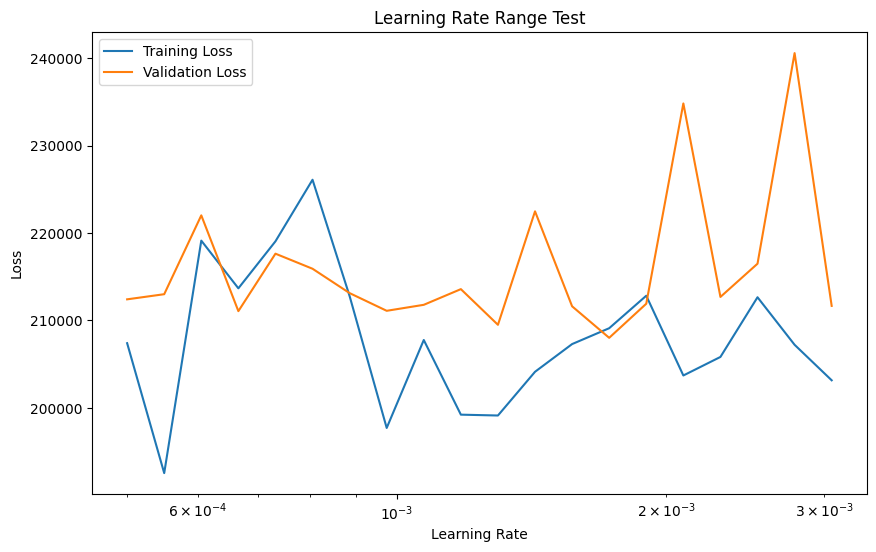

In [6]:
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

# Define a learning rate range test
def lr_schedule(epoch, lr):
    return lr * 1.1  # Increase learning rate by 10% every epoch

# Callback to schedule learning rate
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model with the learning rate scheduler
history_lr_test = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=20,  # Use a few epochs to test learning rates
    batch_size=32,
    verbose=2,
    callbacks=[lr_scheduler]
)

# Plot the learning rate vs. loss
lrs = [0.0005 * (1.1 ** i) for i in range(len(history_lr_test.history['loss']))]
plt.figure(figsize=(10, 6))
plt.plot(lrs, history_lr_test.history['loss'], label='Training Loss')
plt.plot(lrs, history_lr_test.history['val_loss'], label='Validation Loss')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate Range Test')
plt.legend()
plt.show()

we tried different learning rate and found that when learning rate = 0.001, this graph looks the best. We evaluated the model using MSE, RMSE, MAE, and R².
MAE of 343.11 euros indicates the average magnitude of prediction error.
An RMSE of 494.27 means that, on average, the model's predictions deviate by 494 euros from the actual prices.
The R² of 0.6058 suggests that the model explains 60.6% of the variance in Price_euros.

In [25]:
# check in 3 starts here
# Convert RetinaDisplay column to numerical values
df_train['RetinaDisplay'] = df_train['RetinaDisplay'].map({'Yes': 1, 'No': 0})

<ipython-input-25-32c38df59492>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
# train a logistic regression to classify RetinaDisplay (binary) with Price_euros, ScreenW, ScreenH
lr = LogisticRegression(solver='liblinear')
lr.fit(X=df_train[['Price_euros', 'ScreenW', 'ScreenH']], y=df_train['RetinaDisplay'])
lr.intercept_, lr.coef_

(array([-2.37366712]), array([[ 0.00061587, -0.0181776 ,  0.02885597]]))

In [31]:
# Create a DataFrame that stores the logistic regression prediction results
lr_result = pd.DataFrame(
    {
        'true_RetinaDisplay': df_train['RetinaDisplay'],
        'lr_predict': lr.predict_proba(df_train[['Price_euros', 'ScreenW', 'ScreenH']])[:, 1],
        'lr_predict_binary': lr.predict(df_train[['Price_euros', 'ScreenW', 'ScreenH']])
    }
)
lr_result

,true_RetinaDisplay,lr_predict,lr_predict_binary
0,0,0.009753,0
1,0,0.005318,0
2,0,0.008337,0
3,0,0.006096,0
4,0,0.002881,0
...,...,...,...
760,0,0.003838,0
761,0,0.008701,0
762,0,0.008386,0
763,0,0.002973,0


In [32]:
# compute the confusion matrix based on lr_result
conf_lr = confusion_matrix(y_true=lr_result['true_RetinaDisplay'],
                           y_pred=lr_result['lr_predict_binary'])
conf_lr

array([[748,   7],
       [  9,   1]])

In [33]:
# prediction_accuracy & error
lr_accuracy = (conf_lr[0, 0] + conf_lr[1, 1]) / conf_lr.sum()
lr_error = (conf_lr[0, 1] + conf_lr[1, 0]) / conf_lr.sum()

# true_positive_rate & true_negative_rate
true_positive_rate = conf_lr[1, 1] / (conf_lr[1, 1] + conf_lr[1, 0])
true_negative_rate = conf_lr[0, 0] / (conf_lr[0, 0] + conf_lr[0, 1])

print('prediction accuracay:', lr_accuracy)
print('prediction error:', lr_error)
print('true positive rate:', true_positive_rate)
print('true negative rate:', true_negative_rate)

prediction accuracay: 0.9790849673202614
prediction error: 0.02091503267973856
true positive rate: 0.1
true negative rate: 0.990728476821192


In [34]:
px.histogram(lr_result, x='lr_predict', color='true_RetinaDisplay',
             nbins=20, opacity=0.5,
             barmode='overlay')

In [35]:
# compute the ROC curve variables
lr_result_val = pd.DataFrame(
    {
        'true_RetinaDisplay': df_val['RetinaDisplay'],
        'lr_predict': lr.predict_proba(df_val[['Price_euros', 'ScreenW', 'ScreenH']])[:, 1],
        'lr_predict_binary': lr.predict(df_val[['Price_euros', 'ScreenW', 'ScreenH']])
    }
)
lr_result_val['lr_predict_0.12'] = (lr_result_val['lr_predict'] >= 0.12).astype(int)
lr_result_val['true_RetinaDisplay'] = lr_result_val['true_RetinaDisplay'].map({'Yes': 1, 'No': 0})

lr_result_val

,true_RetinaDisplay,lr_predict,lr_predict_binary,lr_predict_0.12
765,0,0.009014,0,0
766,0,0.003824,0,0
767,0,0.018793,0,0
768,1,0.145256,0,1
769,0,0.003615,0,0
...,...,...,...,...
1078,0,0.005227,0,0
1079,0,0.003403,0,0
1080,0,0.000269,0,0
1081,0,0.001802,0,0


In [36]:
# Create a DataFrame that stores the logistic regression prediction  on df_val
fpr, tpr, thresholds = metrics.roc_curve(lr_result_val['true_RetinaDisplay'],
                                            lr_result_val['lr_predict'])
thresholds

array([           inf, 7.62673103e-01, 6.65460070e-01, 1.27328022e-01,
       1.22991168e-01, 1.20679583e-01, 8.64812711e-03, 8.62703249e-03,
       7.32381850e-03, 7.24387746e-03, 6.91049104e-03, 6.88517796e-03,
       6.76412358e-03, 6.67778536e-03, 6.51005214e-03, 6.47659902e-03,
       6.32072134e-03, 6.28143563e-03, 6.17848886e-03, 6.17163944e-03,
       5.68141248e-03, 5.55752700e-03, 5.45634382e-03, 5.45300278e-03,
       5.39288057e-03, 5.38990833e-03, 5.25300120e-03, 5.22731858e-03,
       5.07271577e-03, 5.06960844e-03, 4.85891020e-03, 4.82706159e-03,
       4.76825140e-03, 4.71015433e-03, 4.68137053e-03, 4.61300172e-03,
       4.58601764e-03, 4.56797558e-03, 4.47374240e-03, 4.44639686e-03,
       4.36000446e-03, 4.34932359e-03, 4.32273526e-03, 4.31214529e-03,
       4.09060701e-03, 4.04073294e-03, 3.99391365e-03, 3.94037649e-03,
       3.86524770e-03, 3.84722055e-03, 3.82368989e-03, 3.80030260e-03,
       3.73479436e-03, 3.72641666e-03, 3.69456593e-03, 3.66294147e-03,
      

In [37]:
# plot ROC curve
roc_lr = pd.DataFrame({
    'False Positive Rate':fpr,
    'True Positive Rate': tpr,
    'Model': 'Logistic Regression'
})
roc_df = pd.concat([roc_lr])
px.line(roc_df, x='False Positive Rate', y='True Positive Rate',color='Model',
        width=700, height=500)

In [38]:
# compute auc
lr_auc = metrics.roc_auc_score(lr_result_val['true_RetinaDisplay'],
                                  lr_result_val['lr_predict'])
print('Logistic regression AUC:', lr_auc.round(3))

Logistic regression AUC: 0.993


In [39]:
from sklearn.model_selection import cross_val_score
# this is rather inaccurate since RetinaDisplay are mostly 0 and only a few of 1

np.random.seed(148)
cv_scores_accuracy = cross_val_score(lr,
                        X=df_val[['Price_euros', 'ScreenW', 'ScreenH']],
                        y=df_val['RetinaDisplay'], cv=5, scoring='accuracy')
print('Cross-validation accuracy scores:', cv_scores_accuracy)
print('Mean cross-validation accuracy:', cv_scores_accuracy.mean().round(3))

cv_scores_auc = cross_val_score(lr,
                        X=df_val[['Price_euros', 'ScreenW', 'ScreenH']],
                        y=df_val['RetinaDisplay'], cv=5, scoring='roc_auc')
print('Cross-validation AUC scores:', cv_scores_auc)
print('Mean cross-validation AUC:', cv_scores_auc.mean().round(3))

Cross-validation accuracy scores: [0.984375   0.984375   0.96875    0.98412698 0.98412698]
Mean cross-validation accuracy: 0.981
Cross-validation AUC scores: [0.98412698 1.         0.96774194 0.98387097 1.        ]
Mean cross-validation AUC: 0.987


In [40]:
desired_tpr = 0.5
threshold = thresholds[np.argmax(tpr >= desired_tpr)]
print('Threshold for desired TPR:', threshold)

Threshold for desired TPR: 0.12732802180041547


In [41]:
df_val.groupby('RetinaDisplay').count()

,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,...,IPSpanel,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
RetinaDisplay,,,,,,,,,,,,,,,,,,,,,
No,312,312,312,312,312,312,312,312,312,312,...,312,312,312,312,312,312,312,312,312,312
Yes,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6


The ROC curve looks almost like an perfect ROC curve. In the validaton set, we have 312 No and only 6 Yes. Given the high imbalance, I think selecting a threshold ~0.12 would be ideal if our purpose is to capture as many positives as possible while keeping false positives under a reasonable amount.

In [42]:
# check in 4 starts here
from sklearn.ensemble import RandomForestClassifier
# from sklearn.inspection import permutation_importance

# fit RF to predict RentinaDisplay on train set with ['Price_euros', 'ScreenW', 'ScreenH']
rf = RandomForestClassifier(random_state=148)
rf.fit(X=df_train[['Price_euros', 'ScreenW', 'ScreenH']], y=df_train['RetinaDisplay'])

# compute probability RF prediction on training set
rf_result_train = pd.DataFrame(
    {
        'true_RetinaDisplay': df_train['RetinaDisplay'],
        'rf_predict': rf.predict_proba(df_train[['Price_euros', 'ScreenW', 'ScreenH']])[:, 1],
        'rf_predict_binary': rf.predict(df_train[['Price_euros', 'ScreenW', 'ScreenH']])
        }
)

rf_result_train[rf_result_train['rf_predict']!=0].head(10) # check for non-zero rf_predict

,true_RetinaDisplay,rf_predict,rf_predict_binary
8,1,0.78,1
10,0,0.01,0
32,0,0.08,0
57,0,0.11,0
61,0,0.15,0
66,0,0.01,0
68,0,0.02,0
95,0,0.20,0
168,0,0.01,0
180,0,0.14,0


In [43]:
# Calculate the confusion matrix, prediction accuracy, prediction error,
# true positive rate, and true negative rate, and F1 score on your training set
conf_rf = confusion_matrix(y_true=rf_result_train['true_RetinaDisplay'],
                           y_pred=rf_result_train['rf_predict_binary'])
conf_rf

array([[755,   0],
       [  0,  10]])

In [44]:
pred_accuracy_rf = (conf_rf[0, 0] + conf_rf[1, 1]) / conf_rf.sum()
pred_error_rf = (conf_rf[0, 1] + conf_rf[1, 0]) / conf_rf.sum()
true_positive_rate_rf = conf_rf[1, 1] / (conf_rf[1, 1] + conf_rf[1, 0])
true_negative_rate_rf = conf_rf[0, 0] / (conf_rf[0, 0] + conf_rf[0, 1])
f1_score_rf = metrics.f1_score(y_true=rf_result_train['true_RetinaDisplay'],
                               y_pred=rf_result_train['rf_predict_binary'])

print('Prediction accuracy:', pred_accuracy_rf)
print('Prediction error:', pred_error_rf)
print('True positive rate:', true_positive_rate_rf)
print('True negative rate:', true_negative_rate_rf)
print('F1 score:', f1_score_rf)

Prediction accuracy: 1.0
Prediction error: 0.0
True positive rate: 1.0
True negative rate: 1.0
F1 score: 1.0


With Random forest, we achieve 100% prediction accuracy on train set. But as previously mentioned in the project, the particularly reason for this high accruacy may due to the fact that there're only a few No and the majority of the binary variable (RetinaDisplay) is Yes.

In [45]:
# Calculate and plot the ROC curve and AUC on your validation data set
rf_result_val = pd.DataFrame(
    {
        'true_RetinaDisplay': df_val['RetinaDisplay'].map({'No': 0, 'Yes': 1}),
        'rf_predict': rf.predict_proba(df_val[['Price_euros', 'ScreenW', 'ScreenH']])[:, 1],
        'rf_predict_binary': rf.predict(df_val[['Price_euros', 'ScreenW', 'ScreenH']])
    }
)

fpr, tpr, thresholds = metrics.roc_curve(rf_result_val['true_RetinaDisplay'],
                                            rf_result_val['rf_predict'])

roc_rf = pd.DataFrame({
    'False Positive Rate':fpr,
    'True Positive Rate': tpr,
    'Model': 'Random Forest'
})
roc_df = pd.concat([roc_lr, roc_rf])
px.line(roc_df, x='False Positive Rate', y='True Positive Rate',color='Model',
        width=700, height=500)

# We achieved a almost perfect ROC curve.

In [46]:
conf_rf_val = confusion_matrix(y_true=rf_result_val['true_RetinaDisplay'],
                           y_pred=rf_result_val['rf_predict_binary'])
conf_rf_val

array([[312,   0],
       [  1,   5]])

In [47]:
# compute the AUC for RF on validation set
rf_auc = metrics.roc_auc_score(rf_result_val['true_RetinaDisplay'],
                                  rf_result_val['rf_predict'])
print('Random forest AUC:', rf_auc.round(3))

Random forest AUC: 1.0


In [48]:
# Use 5-fold cross-validation on the validation set to calculate the AUC and accuracy of each fold
cv_scores_accuracy_rf = cross_val_score(rf,
                        X=df_val[['Price_euros', 'ScreenW', 'ScreenH']],
                        y=df_val['RetinaDisplay'], cv=5, scoring='accuracy')
print('Cross-validation accuracy scores (RF):', cv_scores_accuracy_rf)
print('Mean cross-validation accuracy (RF):', cv_scores_accuracy_rf.mean().round(3))

cv_scores_auc_rf = cross_val_score(rf,
                        X=df_val[['Price_euros', 'ScreenW', 'ScreenH']],
                        y=df_val['RetinaDisplay'], cv=5, scoring='roc_auc')
print('Cross-validation AUC scores (RF):', cv_scores_auc_rf)
print('Mean cross-validation AUC (RF):', cv_scores_auc_rf.mean().round(3))

Cross-validation accuracy scores (RF): [1.       1.       0.984375 1.       1.      ]
Mean cross-validation accuracy (RF): 0.997
Cross-validation AUC scores (RF): [1. 1. 1. 1. 1.]
Mean cross-validation AUC (RF): 1.0


We trained random forest on the train set on same predictors we used for logistic regression, 'Price_euros', 'ScreenW', 'ScreenH'. Both have a great perforamce, and RF has better performance than losgistic regression in terms of CV accuracy and AUC.

In [49]:
# check in 5 starts here
# take all the continuous variable from df_train and apply PCA
from itertools import product
continuous_vars = df_train.select_dtypes(include=['float64', 'int64'])
continuous_vars = (continuous_vars - continuous_vars.mean()) / continuous_vars.std()
pca_U, pca_d, pca_V = np.linalg.svd(continuous_vars)
pca_U.shape, pca_V.shape, pca_d.shape

((765, 765), (10, 10), (10,))

In [50]:
pca_d

array([50.39156377, 42.09941238, 30.26010133, 26.5638766 , 25.31251022,
       22.12427677, 17.51616859, 12.38801766, 10.66608752,  1.66287203])

In [ ]:
# compute variability explained by each variabel and
# cumulative variabillity explained of first N PC
prop_var = np.square(pca_d) / sum(np.square(pca_d))
df_pc = pd.DataFrame(
    {"PC": 1 + np.arange(0, prop_var.shape[0]),
     "variability_explained": prop_var.round(3),
     "cumulative_variability_explained": prop_var.cumsum().round(3)
     })
df_pc

,PC,variability_explained,cumulative_variability_explained
0,1,0.332,0.332
1,2,0.232,0.564
2,3,0.120,0.684
3,4,0.092,0.777
4,5,0.084,0.860
5,6,0.064,0.925
6,7,0.040,0.965
7,8,0.020,0.985
8,9,0.015,1.000
9,10,0.000,1.000


In [52]:
# put the loadings for PC1 in a dataframe
loadings1 = pd.DataFrame(
    {"orig_var": continuous_vars.columns,
     "pc1_loading": pca_V[0]
     })
# look at the 10 largest (absolute value) loadings for PC1 but print out the signed value
loadings1.reindex(loadings1["pc1_loading"].abs().sort_values(ascending=False).index) \
    .head(10)

,orig_var,pc1_loading
3,Price_euros,-0.453729
1,Ram,-0.442171
4,ScreenW,-0.378850
5,ScreenH,-0.374110
7,CPU_freq,-0.303301
9,SecondaryStorage,-0.299197
2,Weight,-0.281619
0,Inches,-0.217779
6,RetinaDisplay,-0.071343
8,PrimaryStorage,0.042341


In [53]:
# put the loadings for PC2 in a dataframe
loadings2 = pd.DataFrame(
    {"orig_var": continuous_vars.columns,
     "pc2_loading": pca_V[1]
     })
# look at the 10 largest (absolute value) loadings for PC2 but print out the signed value
loadings2.reindex(loadings2["pc2_loading"].abs().sort_values(ascending=False).index) \
    .head(10)

,orig_var,pc2_loading
0,Inches,-0.514339
2,Weight,-0.496005
5,ScreenH,0.398576
4,ScreenW,0.380308
6,RetinaDisplay,0.229577
9,SecondaryStorage,-0.228705
8,PrimaryStorage,-0.210739
7,CPU_freq,-0.141750
3,Price_euros,0.125159
1,Ram,-0.027508


Looks like ScreenH and ScreenW are shared by loadings of PC1 and PC2 as 2 out of the top 4 variables that contribute the most to the PC construction. For the rest, the contribution of original variables are different: Price_euros and RAM contributes the most to PC1, but for PC2 Inches and Weight contributes the most.

In [ ]:
# scree plot
px.line(x = np.arange(prop_var.shape[0]),
        y = prop_var,
        labels={"x": "PC",
                "y": "Proportion explained"}
      )

Based on the scree plot and the dataframe for cumulative variability explained, the first 5 PCs accounted for 0.860 of the total variability; the first 6 PCs explained 0.925 of the total variability, rendering the last four PC redundant. Here we use first 5 PCs and do dimensionality reduction.

In [ ]:
# dimensionality reduction with 5 PCs
num_pcs = 5
reduced_data = np.dot(continuous_vars, pca_V[:num_pcs].T)
reduced_df = pd.DataFrame(reduced_data, columns=[f"PC{i+1}" for i in range(num_pcs)])
reduced_df

,PC1,PC2,PC3,PC4,PC5
0,-2.028057,-0.313749,-0.182939,-0.719105,-1.235775
1,0.195695,1.122780,-0.343567,-0.742360,-0.789761
2,0.560113,-1.826601,1.380962,-0.814002,-1.749986
3,-0.284406,1.598801,-0.065150,-1.183971,-1.277260
4,1.001456,-0.542228,1.450145,0.269692,0.990821
...,...,...,...,...,...
760,0.029598,-0.670906,1.495280,-0.219780,0.101779
761,1.552972,-1.019775,0.071639,-0.026971,-0.538494
762,-0.700958,0.311151,-0.235006,-0.499925,-0.646506
763,0.989546,-0.495252,1.441506,0.243468,0.958561
